In [16]:
import random
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from iagos_toolkit.flight.aircraft_performance import create_flight_from_iagos

In [17]:
DATASET_LOCATION = "../../data/collocations"

df = pd.read_csv('../../data/landsat_sentinel_collocations_20260212.csv')

In [18]:
df = df[df["air_temperature_iagos_validity"] <= 0]
df = df[df["rhl_iagos_validity"] <= 0]
df = df[df["contrail_formation"].notna()]
df = df[df["efficiency_PS_IAGOS"].notna()]
# df = df[df["efficiency_BADA4_IAGOS"].notna()]

df

,path,satellite,scene_id,sensing_time,crs,extent,visualization_url,icao24,registration,icao_code,...,eastward_wind_iagos,air_temperature_era5,rhl_era5,rhi_era5,northward_wind_era5,eastward_wind_era5,efficiency_PS_IAGOS,efficiency_BADA4_IAGOS,efficiency_PS_ERA5,efficiency_BADA4_ERA5
0,intersects_landsat/2013/2013061301394804_LC812...,Landsat,LC81230482013164LGN01,2013-06-13T03:01:57.419284Z,EPSG:32649,"[375270.0, 415230.0, 1887930.0, 1911900.0]",NaN,899118,B-18806,A343,...,-4.606446,227.460710,0.627994,0.963466,3.503712,-1.993433,0.323797,0.304126,0.321805,0.300653
42,intersects_landsat/2022/2022050909094906_LC804...,Landsat,LC80460272022129LGN00,2022-05-09T18:55:24.821202Z,EPSG:32610,"[576030.0, 616020.0, 5291580.0, 5315550.0]",NaN,3C6565,D-AIKE,A333,...,1.619055,256.442185,0.722219,0.850710,-2.120831,1.105809,0.121737,0.000000,0.122808,0.000000
43,intersects_landsat/2022/2022022110014916_LC919...,Landsat,LC91960242022052LGN01,2022-02-21T10:21:40.161875Z,EPSG:32632,"[416610.0, 456570.0, 5695350.0, 5719320.0]",NaN,3C656F,D-AIKO,A333,...,21.366187,225.659507,0.118767,0.185070,-12.969989,24.318870,0.326497,0.249609,0.327517,0.231190
44,intersects_landsat/2022/2022032810020516_LC920...,Landsat,LC92010232022087LGN01,2022-03-28T10:51:50.064664Z,EPSG:32631,"[387420.0, 427410.0, 5905860.0, 5929830.0]",NaN,3C656F,D-AIKO,A333,...,7.650000,213.497185,0.108618,0.184906,5.980913,6.402760,0.337339,0.322530,0.338336,0.317442
45,intersects_landsat/2022/2022101609112116_LC801...,Landsat,LC80140232022289LGN00,2022-10-16T15:36:44.580630Z,EPSG:32619,"[455430.0, 495420.0, 5889390.0, 5913360.0]",NaN,3C656F,D-AIKO,A333,...,9.699032,224.078362,0.024097,0.037994,30.058658,7.978957,0.337613,0.316230,0.339185,0.315257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,intersects_sentinel/2018/2018072409002215_L1C_...,Sentinel,L1C_T21TWN_A007215_20180724T144754,2018-07-24 14:49:33.235331+00:00,EPSG:32621,"[499980.0, 609770.0, 5190250.0, 5300040.0]",NaN,3C656F,D-AIKO,A333,...,19.570000,218.467304,0.604194,0.993962,-21.462752,19.780225,0.339294,0.319525,0.341911,0.319548
740,intersects_sentinel/2018/2018020800540710_L1C_...,Sentinel,L1C_T53SMT_A013742_20180208T015321,2018-02-08 01:57:54.867618+00:00,EPSG:32653,"[399960.0, 509750.0, 3690250.0, 3800040.0]",NaN,8991BD,B-18316,A333,...,55.655886,226.787049,0.025595,0.039489,10.899633,58.856363,0.339680,0.315129,0.343551,0.318082
741,intersects_sentinel/2018/2018101408270502_L1C_...,Sentinel,L1C_T11SLA_A008390_20181014T185358,2018-10-14 18:53:58.820000+00:00,EPSG:32611,"[300000.0, 409790.0, 3990250.0, 4100040.0]",NaN,3C64F4,D-AIGT,A343,...,19.890900,224.379852,0.052534,0.082635,0.070418,20.930452,0.325817,0.301222,0.324529,0.300083
742,intersects_sentinel/2018/2018122515202308_L1C_...,Sentinel,L1C_T17TPH_A009418_20181225T160841,2018-12-25 16:11:25.710000+00:00,EPSG:32617,"[600000.0, 709790.0, 4690210.0, 4800000.0]",NaN,A46AD6,N384HA,A332,...,35.810000,222.191007,0.037725,0.060363,-3.408974,34.303424,0.315908,0.330889,0.319672,0.324406


In [19]:
def split_on_antimeridian(lons, lats):
    """
    Splits a flight track whenever longitude jumps across the antimeridian.
    Returns list of (lon_segment, lat_segment)
    """
    lons = np.asarray(lons)
    lats = np.asarray(lats)

    # Find where |Δlon| > 180° (antimeridian crossing)
    jumps = np.where(np.abs(np.diff(lons)) > 180)[0]

    # If no jumps, return whole track
    if len(jumps) == 0:
        return [(lons, lats)]

    segments = []
    start = 0

    for j in jumps:
        # End the current segment at j
        segments.append((lons[start:j+1], lats[start:j+1]))
        start = j + 1

    # Last segment
    segments.append((lons[start:], lats[start:]))

    return segments


In [20]:
# Creating the bar plot information
satellites = df["satellite"].tolist()
unique_sats = list(set(satellites))

years = pd.to_datetime(df["sensing_time"].to_list(), format="mixed").year
df_temp = pd.DataFrame({"year": years, "satellite": satellites})
df_temp["family"] = df_temp["satellite"].apply(lambda x: "Sentinel" if "Sentinel" in x else "Landsat")
counts = df_temp.groupby(["year", "family"]).size().reset_index(name="count")
pivot = counts.pivot(index="year", columns="family", values="count").fillna(0)

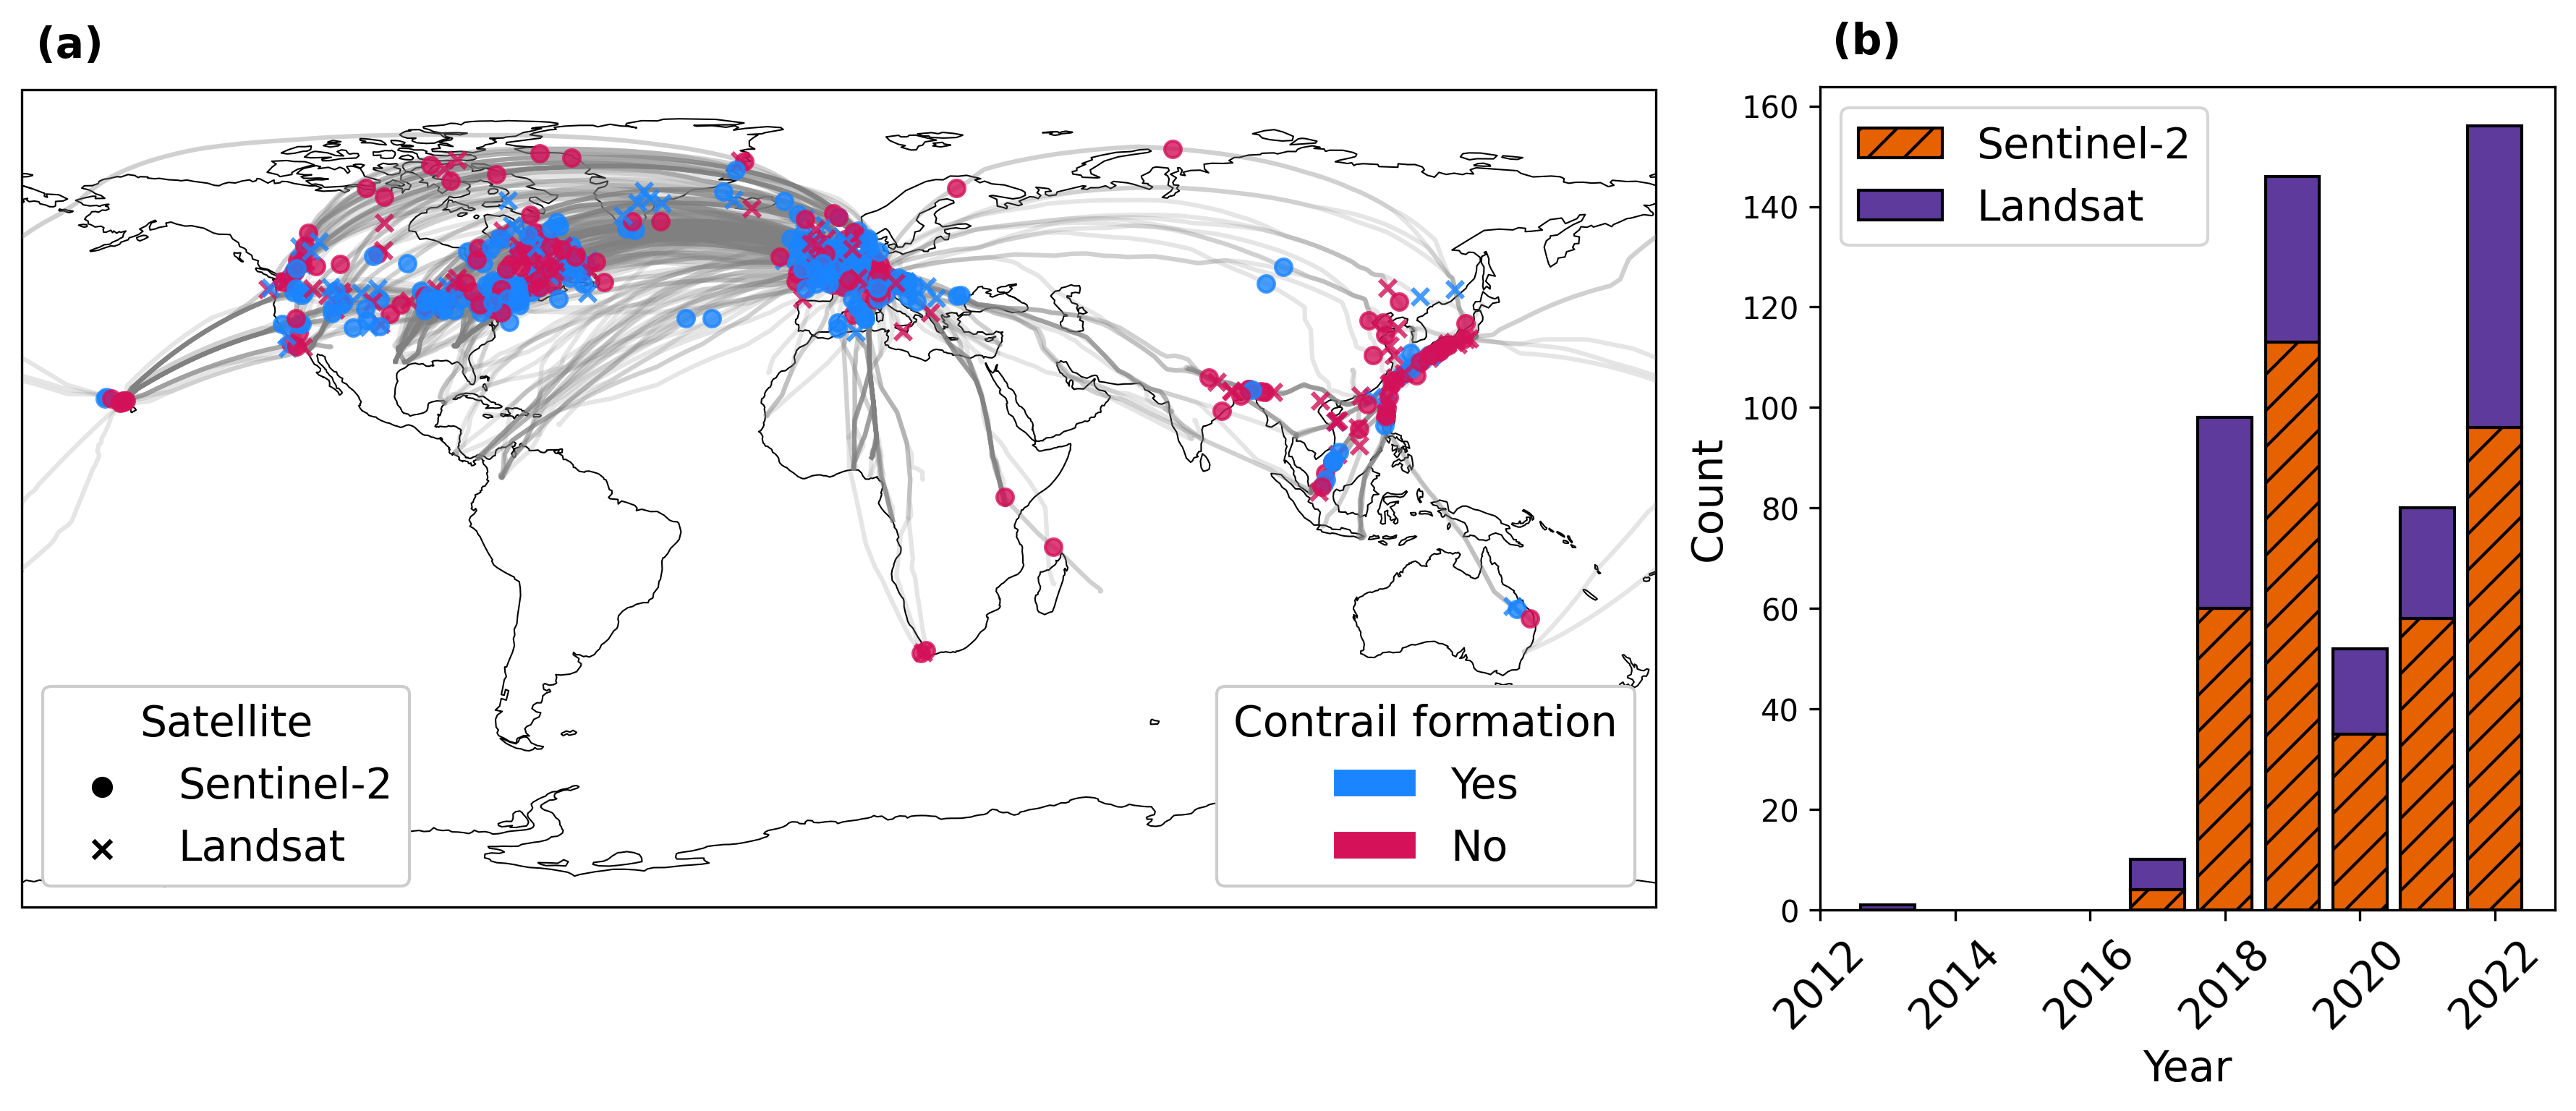

In [21]:
# Styling configuration
satellite_color_map = {
    "Sentinel": "#E66100",
    "Landsat": "#5D3A9B"
}

sat_marker_map = {
    "Sentinel": "o",
    "Landsat": "x"
}

contrail_formation_map = {
    True: "#1A85FF",
    False: "#D41159"
}

# Create figure layout
fig = plt.figure(figsize=(12, 6), dpi=300)

# 1 × 3 grid: map spans first two columns, bar plot third column
gs = fig.add_gridspec(
    nrows=1,
    ncols=3,
    width_ratios=[1, 1, 1],
)

# Left: map
ax_map = fig.add_subplot(gs[0, :2], projection=ccrs.PlateCarree())

# Right: bar chart
ax_bar = fig.add_subplot(gs[0, 2])

# ----------------------------------------------------------
# (a) Map: collocations + flight tracks
ax_map.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax_map.set_global()

# Plot collocation points (randomized order)
data = list(zip(
    df["longitude"],
    df["latitude"],
    satellites,
    df["contrail_formation"]
))

random.shuffle(data)

for lon, lat, sat, contrail in data:
    ax_map.scatter(
        lon,
        lat,
        color=contrail_formation_map.get(contrail, "black"),
        marker=sat_marker_map.get(sat, "x"),
        s=30,
        alpha=0.8,
        transform=ccrs.PlateCarree(),
        zorder=5,
    )

# Plot flight tracks
df_shuffled = df.sample(frac=1).reset_index(drop=True)

for idx, row in df_shuffled.iterrows():
    try:
        with open(f"{DATASET_LOCATION}/{row['path']}/metadata.json", "r") as f:
            metadata = json.load(f)
    except Exception as e:
        print(f"Error loading metadata for row {idx}: {e}")
        continue

    flight = create_flight_from_iagos(
        f"{DATASET_LOCATION}/{row['path']}/{metadata['iagos_data']['filename']}",
        "A320",
        resample=True
    )

    lon = flight["longitude"]
    lat = flight["latitude"]

    segments = split_on_antimeridian(lon, lat)

    for seg_lon, seg_lat in segments:
        ax_map.plot(
            seg_lon,
            seg_lat,
            color="grey",
            alpha=0.2,
            zorder=4,
            transform=ccrs.PlateCarree()
        )

# Map legends
sat_handles = [
    ax_map.scatter([], [], color="black",
                   marker=sat_marker_map["Sentinel"],
                   label="Sentinel-2"),
    ax_map.scatter([], [], color="black",
                   marker=sat_marker_map["Landsat"],
                   label="Landsat"),
]

sat_legend = ax_map.legend(
    handles=sat_handles,
    title="Satellite",
    loc="lower left",
    fontsize=14,
    title_fontsize=14,
    framealpha=1.0
)

ax_map.add_artist(sat_legend)

# Contrail legend (color)
contrail_handles = [
    Patch(
        facecolor=contrail_formation_map[True],
        edgecolor="white",
        label="Yes"
    ),
    Patch(
        facecolor=contrail_formation_map[False],
        edgecolor="white",
        label="No"
    ),
]

ax_map.legend(
    handles=contrail_handles,
    title="Contrail formation",
    loc="lower right",
    fontsize=14,
    title_fontsize=14,
    framealpha=1.0
)

ax_map.text(
    0.05,
    1.08,
    "(a)",
    transform=ax_map.transAxes,
    ha="right",
    va="top",
    fontsize=14,
    fontweight="bold"
)

# -----------------------------------------
# (b) Dates: collocations per year

ax_bar.bar(
    pivot.index,
    pivot["Sentinel"],
    label="Sentinel-2",
    color=satellite_color_map["Sentinel"],
    edgecolor="black",
    hatch='//'
)

ax_bar.bar(
    pivot.index,
    pivot["Landsat"],
    bottom=pivot["Sentinel"],
    label="Landsat",
    color=satellite_color_map["Landsat"],
    edgecolor="black"
)

ax_bar.legend(fontsize=14, loc="upper left")

ax_bar.set_xlabel("Year", fontsize=14)
ax_bar.set_ylabel("Count", fontsize=14)
ax_bar.set_xticks([2012, 2014, 2016, 2018, 2020, 2022])
ax_bar.tick_params(axis="x", rotation=45, labelsize=14)
ax_bar.set_box_aspect(1.12)


# Panel label (b)
ax_bar.text(
    0.11,
    1.08,
    "(b)",
    transform=ax_bar.transAxes,
    ha="right",
    va="top",
    fontsize=14,
    fontweight="bold"
)


# Final layout + export
plt.tight_layout()
plt.savefig(
    "figures/figure_4.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1
)
plt.show()